In [67]:
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with open('data_raw.json', 'r')as read_file:
    data = json.load(read_file)

In [68]:

pd.set_option('display.max_rows', None)
 
pd.set_option('display.max_columns', None)

users = []

for name in data:
    user = data[name]
    if 'anketa' in user and 'gilbert' in user and user['anketa']['age'] < 100:
        user['results'] = user['anketa']
        user['results'] = user['results'] | {'name': name}
        if 'email' in user:
            user['results']['email'] = user['email']
        else:
            user['results']['email'] = ''

        user['results']['browser'] = user['browser']
        user['results']['datetime'] = datetime.fromtimestamp(user['datetime']['seconds'])
        user['results']['mobile'] = user['mobile']
        user['results']['os'] = user['os']
        user['results']['screen'] = user['screen']

        user['name'] = name
        users.append(user)


for user in users:
    annet = user['annet']

    left = 0
    right = 0
    both = 0


    for key in annet:
        single_annet = annet[key]
        
        if single_annet == 'right':
            right += 1

        if single_annet == 'left':
            left += 1

        if single_annet == 'both':
            both += 1

    if left >= 6:
        res = 'left'
    else:
        res = 'right'


    user['results'] = user['results'] | {'annet_left': left, 'annet_right': right, 'annet_both':both, 'annet':res}


for user in users:
    ishihara = user['ishihara']
    
    count = 0
    for answer in ishihara:
        
        if str(answer['value']) == answer['userAnswer']:
            count += 1 

    user['results'] = user['results'] | {'ishihara': count} 

for user in users:
    stroop = user['stroop']

    reaction_left = 0
    reaction_right = 0

    right_correct = 0
    left_correct = 0

    for s in stroop:
        if s['congruents']:
            if s['correctly']:
                reaction_left += s['reaction_time']
                left_correct += 1
        else:
            if s['correctly']:
                reaction_right += s['reaction_time']
                right_correct += 1

    user['results'] = user['results'] | {
        'stroop_correct': left_correct + right_correct,
        'stroop_r_left': reaction_left/left_correct,
        'stroop_r_right': reaction_right/right_correct
    } 
    

for user in users:
    gilbert = user['gilbert']

    res = {}

    for i, g in enumerate(gilbert):
        if i%21 == 0:
            continue
        if g['reaction_time'] > 3000:
            continue

        color_pair_index = i//21 + 1

        if g['direction']:
            direction = 'l'
        else:
            direction = 'r'
        
        if color_pair_index not in res:
            res[color_pair_index] = {}

        if direction not in res[color_pair_index]:
            res[color_pair_index][direction] = {
                'c': 0,
                't': 0,
            }

        if g['correctly']:
            res[color_pair_index][direction]['c'] += 1
            res[color_pair_index][direction]['t'] += g['reaction_time']

    for color_pair_index in res:
        for direction in res[color_pair_index]:
            if res[color_pair_index][direction]['c'] > 0:
                res[color_pair_index][direction]['t'] = round(res[color_pair_index][direction]['t']/res[color_pair_index][direction]['c'])
            else:
                res[color_pair_index][direction]['t'] = 3000

    for color_pair_index in res:
        res[color_pair_index]['d'] = {
            'c': res[color_pair_index]['r']['c'] + res[color_pair_index]['l']['c'], 
            't': res[color_pair_index]['r']['t'] - res[color_pair_index]['l']['t']
        }

    result = {
        f'{color_pair_index}_{key}_{direction}': res[color_pair_index][direction][key]
        for color_pair_index in res
        for direction in res[color_pair_index]
        for key in res[color_pair_index][direction]
    }

    user['results'] = user['results'] | result
    


table = {}
for user in users:
    for key in user['results']:
        if key not in table:
            table[key] = [] 
        if user['results']['ishihara'] < 20:
            continue
        table[key].append(user['results'][key])



user['results']['browser'] = user['browser']
user['results']['datetime'] = user['datetime']
user['results']['mobile'] = user['mobile']
user['results']['os'] = user['os']
user['results']['screen'] = user['screen']

columns = [
    # 'datetime', 
    # 'email', 
    'age', 
    # 'sex', 
    # 'artist_other', 
    # 'education', 
    'synesthesia', 
    # 'visual_diseases_description', 
    'annet',
    # 'annet_right', 
    # 'annet_left', 
    # 'annet_both', 
    'ishihara', 
    'stroop_correct', 
    'stroop_r_left', 
    'stroop_r_right',

    '1_t_l',
    '1_t_r',
    '1_c_l',
    '1_c_r',

    '2_t_l',
    '2_t_r',
    '2_c_l',
    '2_c_r',

    '3_t_l',
    '3_t_r',
    '3_c_l',
    '3_c_r',

    '4_t_l',
    '4_t_r',
    '4_c_l',
    '4_c_r',

    '5_t_l',
    '5_t_r',
    '5_c_l',
    '5_c_r',

    '6_t_l',
    '6_t_r',
    '6_c_l',
    '6_c_r',
]

df = pd.DataFrame(data=table, columns=columns, index=table['name'])

df.to_csv('data_psycat_gilbert_experiment.csv')
df = df.sort_values(by='annet')


df = df.drop(['unstable_teal_chimpanzee','magnanimous_cyan_cuckoo', 'polite_mint_octopus'])

df

,age,synesthesia,annet,ishihara,stroop_correct,stroop_r_left,stroop_r_right,1_t_l,1_t_r,1_c_l,1_c_r,2_t_l,2_t_r,2_c_l,2_c_r,3_t_l,3_t_r,3_c_l,3_c_r,4_t_l,4_t_r,4_c_l,4_c_r,5_t_l,5_t_r,5_c_l,5_c_r,6_t_l,6_t_r,6_c_l,6_c_r
polite_rust_sable,20,no,left,23,24,797.500000,975.000000,1327,938,7,10,823,725,9,7,888,977,10,9,393,432,10,9,647,471,9,10,516,475,10,10
polite_indigo_gerbil,21,yes,left,23,24,834.666667,826.166667,1421,1247,10,10,1308,802,8,9,1018,1465,10,9,720,571,10,10,625,566,10,9,439,448,10,10
polite_lavender_crane,21,yes,left,22,20,982.222222,1046.454545,841,922,10,10,793,1379,9,10,1013,1144,10,9,875,688,10,9,639,610,10,9,600,550,10,10
humility_magenta_cod,28,no,left,20,24,1357.416667,1360.583333,1875,1722,7,7,1726,1385,5,7,1814,1309,7,4,1424,1038,9,10,1058,1086,9,10,783,689,10,10
feebleminded_cyan_pike,21,no,left,20,24,809.916667,1029.750000,921,874,10,10,1072,1470,8,10,1087,1487,9,5,767,998,10,10,690,670,10,10,500,554,10,10
passion_yellow_elephant,31,no,left,23,24,919.583333,836.083333,1464,1386,8,9,925,880,10,10,746,759,10,10,579,620,10,10,654,736,10,10,486,438,10,10
magnanimous_gold_vulture,21,no,left,23,23,891.272727,920.166667,1381,1271,10,9,1268,1179,10,10,1230,1411,10,10,724,527,10,10,741,657,10,10,647,608,10,10
relaxed_rust_seabass,25,yes,left,23,24,1199.916667,904.250000,1808,2312,9,8,1971,1850,8,8,1248,1360,9,10,1006,1026,10,10,877,829,10,10,606,582,10,10
saucy_olive_monkey,22,no,left,22,24,612.166667,813.916667,559,502,10,10,1130,1459,8,9,920,755,10,9,605,656,10,10,508,515,10,10,510,473,10,10
determined_black_deer,32,no,left,21,24,1133.666667,1179.916667,1431,1584,10,10,1898,1437,4,1,998,1127,10,10,597,768,10,10,1246,1181,9,10,1158,1077,10,9


In [69]:

dfl = df.loc[df['annet']=='left']
dfr = df.loc[df['annet']=='right']

In [70]:
dfl.describe()

,age,ishihara,stroop_correct,stroop_r_left,stroop_r_right,1_t_l,1_t_r,1_c_l,1_c_r,2_t_l,2_t_r,2_c_l,2_c_r,3_t_l,3_t_r,3_c_l,3_c_r,4_t_l,4_t_r,4_c_l,4_c_r,5_t_l,5_t_r,5_c_l,5_c_r,6_t_l,6_t_r,6_c_l,6_c_r
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000
mean,24.20000,22.000000,23.500000,953.832828,989.228788,1302.800000,1275.800000,9.100000,9.30000,1291.400000,1256.600000,7.900000,8.100000,1096.200000,1179.40000,9.500000,8.500000,769.000000,732.400000,9.900000,9.800000,768.500000,732.100000,9.700000,9.800000,624.500000,589.400000,10.0,9.900000
std,4.54117,1.247219,1.269296,220.544348,173.894405,416.066448,514.272042,1.286684,1.05935,434.070706,355.863644,1.969207,2.766867,293.632726,275.08633,0.971825,2.173067,285.738031,218.663719,0.316228,0.421637,226.961206,236.516596,0.483046,0.421637,212.176158,188.689162,0.0,0.316228
min,20.00000,20.000000,20.000000,612.166667,813.916667,559.000000,502.000000,7.000000,7.00000,793.000000,725.000000,4.000000,1.000000,746.000000,755.00000,7.000000,4.000000,393.000000,432.000000,9.000000,9.000000,508.000000,471.000000,9.000000,9.000000,439.000000,438.000000,10.0,9.000000
25%,21.00000,21.250000,24.000000,816.104167,853.125000,1022.500000,926.000000,8.250000,9.00000,961.750000,954.750000,8.000000,7.250000,939.500000,1014.50000,9.250000,9.000000,599.000000,583.250000,10.000000,10.000000,641.000000,577.000000,9.250000,10.000000,502.500000,473.500000,10.0,10.000000
50%,21.50000,22.500000,24.000000,905.428030,947.583333,1401.000000,1259.000000,10.000000,10.00000,1199.000000,1382.000000,8.000000,9.000000,1015.500000,1226.50000,10.000000,9.000000,722.000000,672.000000,10.000000,10.000000,672.000000,663.500000,10.000000,10.000000,558.000000,552.000000,10.0,10.000000
75%,27.25000,23.000000,24.000000,1095.805556,1042.278409,1455.750000,1534.500000,10.000000,10.00000,1621.500000,1453.500000,9.000000,10.000000,1194.250000,1398.25000,10.000000,10.000000,848.000000,940.500000,10.000000,10.000000,843.000000,805.750000,10.000000,10.000000,636.750000,601.500000,10.0,10.000000
max,32.00000,23.000000,24.000000,1357.416667,1360.583333,1875.000000,2312.000000,10.000000,10.00000,1971.000000,1850.000000,10.000000,10.000000,1814.000000,1487.00000,10.000000,10.000000,1424.000000,1038.000000,10.000000,10.000000,1246.000000,1181.000000,10.000000,10.000000,1158.000000,1077.000000,10.0,10.000000


In [71]:
dfr.describe()


,age,ishihara,stroop_correct,stroop_r_left,stroop_r_right,1_t_l,1_t_r,1_c_l,1_c_r,2_t_l,2_t_r,2_c_l,2_c_r,3_t_l,3_t_r,3_c_l,3_c_r,4_t_l,4_t_r,4_c_l,4_c_r,5_t_l,5_t_r,5_c_l,5_c_r,6_t_l,6_t_r,6_c_l,6_c_r
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000
mean,30.450000,21.950000,23.600000,949.475758,1125.143182,1167.400000,1175.950000,9.550000,9.300000,1238.400000,1299.150000,8.600000,8.60000,1273.800000,1269.600000,8.5000,8.400000,805.650000,814.850000,9.950000,9.950000,807.250000,829.900000,9.850000,9.800000,597.600000,614.300000,9.75000,9.800000
std,11.199037,1.145931,0.680557,291.251229,334.116441,337.449006,360.629782,0.686333,0.978721,424.617277,350.162861,2.414866,1.46539,431.589547,388.100964,2.3056,1.569445,126.129956,127.935952,0.223607,0.223607,146.425075,144.496913,0.366348,0.410391,119.673855,103.792353,0.71635,0.410391
min,22.000000,20.000000,22.000000,573.750000,681.333333,574.000000,632.000000,8.000000,7.000000,761.000000,573.000000,2.000000,6.00000,661.000000,640.000000,1.0000,5.000000,589.000000,621.000000,9.000000,9.000000,608.000000,587.000000,9.000000,9.000000,440.000000,490.000000,7.00000,9.000000
25%,25.500000,21.000000,23.000000,728.637500,865.520833,993.750000,915.750000,9.000000,9.000000,878.500000,1037.000000,8.750000,7.75000,909.500000,1065.250000,8.0000,7.000000,715.250000,734.000000,10.000000,10.000000,685.500000,745.500000,10.000000,10.000000,520.750000,534.500000,10.00000,10.000000
50%,27.000000,22.000000,24.000000,900.041667,1050.473485,1140.500000,1128.000000,10.000000,10.000000,1146.500000,1317.500000,10.000000,9.00000,1250.000000,1252.000000,9.0000,9.000000,794.500000,791.500000,10.000000,10.000000,796.000000,830.000000,10.000000,10.000000,553.500000,595.500000,10.00000,10.000000
75%,28.750000,23.000000,24.000000,1093.686364,1322.833333,1394.250000,1369.750000,10.000000,10.000000,1437.250000,1565.250000,10.000000,10.00000,1521.750000,1387.000000,10.0000,10.000000,895.750000,873.750000,10.000000,10.000000,872.500000,905.250000,10.000000,10.000000,653.500000,674.250000,10.00000,10.000000
max,56.000000,23.000000,24.000000,1663.083333,1696.166667,1843.000000,1915.000000,10.000000,10.000000,2289.000000,1947.000000,10.000000,10.00000,2284.000000,2071.000000,10.0000,10.000000,1061.000000,1063.000000,10.000000,10.000000,1126.000000,1190.000000,10.000000,10.000000,869.000000,921.000000,10.00000,10.000000


Text(0, 0.5, 'Число испытуемых')

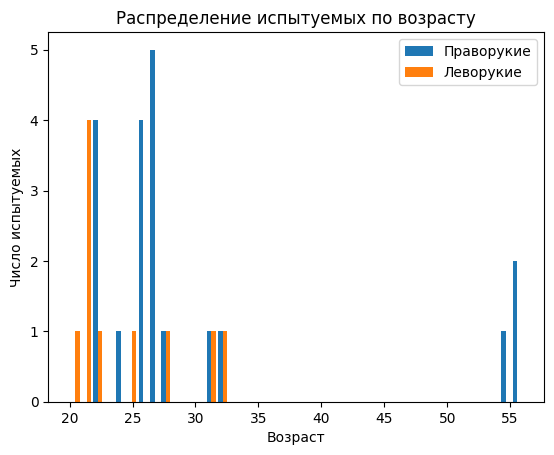

In [72]:

plt.hist([df[df['annet']=='right']['age'], df[df['annet']=='left']['age']], bins = int(40), label=['Праворукие','Леворукие'])
plt.legend()
plt.title('Распределение испытуемых по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Число испытуемых')

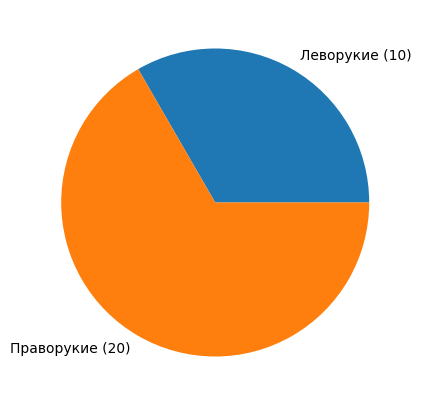

In [73]:
 
# Creating dataset
cars = [f"Леворукие ({len(df[df['annet']=='left'])})", f"Праворукие ({len(df[df['annet']=='right'])})"]
 
data = [len(df[df['annet']=='left']), len(df[df['annet']=='right'])]
 
# Creating plot
fig = plt.figure(figsize =(7, 5))
plt.pie(data, labels = cars, counterclock=True)
 
# show plot
plt.show()

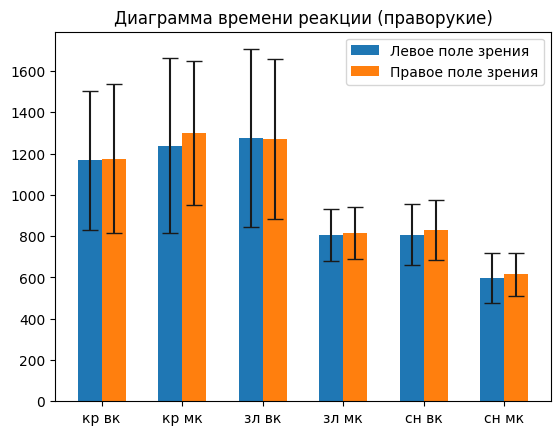

In [74]:

cols_l = [f'{i}_t_l' for i in range(1,7)]
cols_r = [f'{i}_t_r' for i in range(1,7)]
cols_names = ['кр вк','кр мк','зл вк','зл мк','сн вк','сн мк']

values_mean_l = dfr[cols_l].mean().to_numpy()
values_std_l = dfr[cols_l].std().to_numpy()
values_mean_r = dfr[cols_r].mean().to_numpy()
values_std_r = dfr[cols_r].std().to_numpy()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l, error_kw={'ecolor':'0.1','capsize':6}, label='Левое поле зрения')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Правое поле зрения')

ax.set_title('Диаграмма времени реакции (праворукие)')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

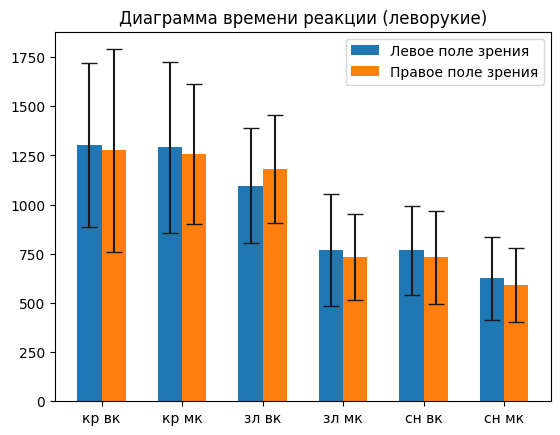

In [75]:
cols_l = [f'{i}_t_l' for i in range(1,7)]
cols_r = [f'{i}_t_r' for i in range(1,7)]
cols_names = ['кр вк','кр мк','зл вк','зл мк','сн вк','сн мк']

values_mean_l = dfl[cols_l].mean().to_numpy()
values_std_l = dfl[cols_l].std().to_numpy()
values_mean_r = dfl[cols_r].mean().to_numpy()
values_std_r = dfl[cols_r].std().to_numpy()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l, error_kw={'ecolor':'0.1','capsize':6}, label='Левое поле зрения')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Правое поле зрения')
ax.set_title('Диаграмма времени реакции (леворукие)')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

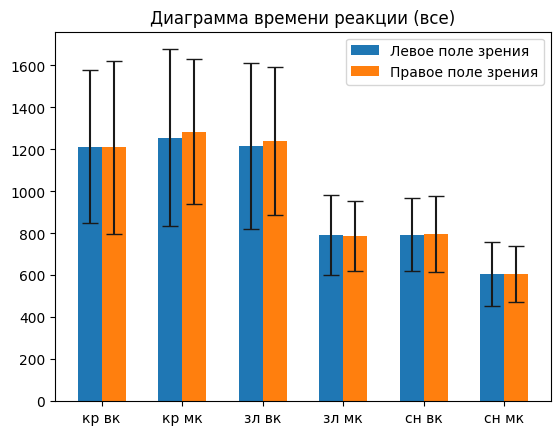

In [76]:
cols_l = [f'{i}_t_l' for i in range(1,7)]
cols_r = [f'{i}_t_r' for i in range(1,7)]
cols_names = ['кр вк','кр мк','зл вк','зл мк','сн вк','сн мк']

values_mean_l = df[cols_l].mean().to_numpy()
values_std_l = df[cols_l].std().to_numpy()
values_mean_r = df[cols_r].mean().to_numpy()
values_std_r = df[cols_r].std().to_numpy()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l, error_kw={'ecolor':'0.1','capsize':6}, label='Левое поле зрения')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Правое поле зрения')
ax.set_title('Диаграмма времени реакции (все)')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()

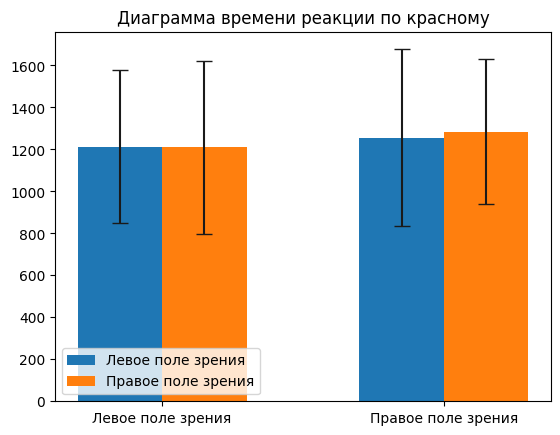

In [77]:
colors = ['#a30cbd', '#1fbd0c']

cols_l = ['1_t_l', '2_t_l']
cols_r = ['1_t_r', '2_t_r']
cols_names = ['Левое поле зрения', 'Правое поле зрения']

values_mean_l = df[cols_l].mean().to_numpy()
values_std_l = df[cols_l].std().to_numpy()
values_mean_r = df[cols_r].mean().to_numpy()
values_std_r = df[cols_r].std().to_numpy()

width = 0.3
x = np.arange(len(cols_names))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_mean_l, width, yerr=values_std_l, error_kw={'ecolor':'0.1','capsize':6}, label='Левое поле зрения')
rects2 = ax.bar(x + width/2, values_mean_r, width, yerr=values_std_r, error_kw={'ecolor':'0.1','capsize':6}, label='Правое поле зрения')
ax.set_title('Диаграмма времени реакции по красному')
ax.set_xticks(x)
ax.set_xticklabels(cols_names)
ax.legend()